# Actor-Critic with LunarLander

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LunarLander

LunarLander is an OpenAI gym environment (env). In this env the agent tries to land a space craft safely on the ground by firing the main, left, or right engine. The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. There are discrete and continuous versions of LunarLander.

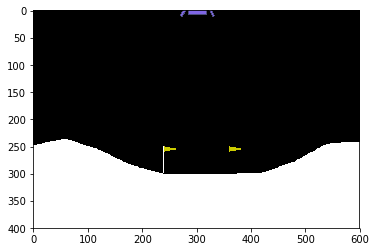

In [3]:
env = gym.make('LunarLander-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

### Actor-Critic Architecture

Actor-critic (AC) combines PG and state value methods. Actor-critic has an actor network for policies and a critic network for estimating state values.  The environment produces an observation of the state. The state is inputted into the policy network to select an action. The agent receives a reward and next state. The agent uses the critic network, reward and next state to evaluate the action. The actor and critic networks are updated using that evaluation, typically with gradient descent. The process is similar to REINFORCE with baselines the key difference being the critic network bootstraps using the next state.

### Discrete Actor-Critic with Lunar Lander

In this example, we will solve the discrete version of Lunar Lander using Actor-Critic.

In [4]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) + 1e-8 #-1 to take softmax of last dimension
    
class CriticNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(CriticNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [5]:
class ActorCriticAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount, entropy_coeff ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.critic_net = CriticNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=critic_lr)
        self.discount = discount
        self.entropy_coeff = entropy_coeff
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list, next_state_list, done_list):
      
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        next_state_t = torch.FloatTensor(next_state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        reward_t = torch.FloatTensor(reward_list).to(device).view(-1,1)
        done_t = torch.FloatTensor(done_list).to(device).view(-1,1) #flipping 0 and 1 in RL training loop
        
        # get critic estimate
        critic_t = self.critic_net(state_t).view(-1,1)
        with torch.no_grad():
            critic_td_t = reward_t + done_t * self.discount * self.critic_net(next_state_t).view(-1,1)
            advantage_t = critic_td_t - critic_t
        
        # get action probabilities
        action_probs = self.actor_net(state_t)
        selected_action_prob = action_probs.gather(1, action_t)
        # calculate entropy loss
        entropy_loss = -torch.sum(action_probs*torch.log(action_probs), dim=1)
        # calculate actor loss
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t + self.entropy_coeff*entropy_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 

        # calculate critic loss
#         loss_fn = nn.MSELoss()
#         critic_loss = loss_fn(critic_t, critic_td_t)
        critic_loss = F.smooth_l1_loss(critic_t, critic_td_t)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
    

In [6]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.00005 # learning rate for actor
critic_lr = 0.00003 # learning rate for critic
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount
entropy_coeff = 0.000001

# create agent
agent = ActorCriticAgent(state_size, action_size, hidden_size, actor_lr, critic_lr, discount, entropy_coeff)

In [7]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        next_state_list.append(next_state)
        done_list.append(1. - float(done))
        
        # train the agent
        actor_loss, critic_loss = agent.train(state_list, action_list, reward_list, next_state_list, done_list)
        stats_actor_loss.append(actor_loss) 
        stats_critic_loss.append(critic_loss) 
  
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state


Episode: 0 Timestep: 60 Total reward: -85.3 Episode length: 60.0 Actor Loss: -0.0094 Critic Loss: 0.0003
Episode: 10 Timestep: 950 Total reward: -255.3 Episode length: 89.0 Actor Loss: -0.0123 Critic Loss: 0.0006
Episode: 20 Timestep: 2385 Total reward: -148.6 Episode length: 143.5 Actor Loss: -0.0059 Critic Loss: 0.0004
Episode: 30 Timestep: 4961 Total reward: -2.7 Episode length: 257.6 Actor Loss: -0.0127 Critic Loss: 0.0003
Episode: 40 Timestep: 6800 Total reward: -60.4 Episode length: 183.9 Actor Loss: -0.0217 Critic Loss: 0.0001
Episode: 50 Timestep: 11432 Total reward: 46.4 Episode length: 463.2 Actor Loss: -0.0235 Critic Loss: 0.0001
Episode: 60 Timestep: 14198 Total reward: -44.2 Episode length: 276.6 Actor Loss: -0.0248 Critic Loss: 0.0001
Episode: 70 Timestep: 19028 Total reward: -16.7 Episode length: 483.0 Actor Loss: -0.0243 Critic Loss: 0.0001
Episode: 80 Timestep: 26722 Total reward: -67.3 Episode length: 769.4 Actor Loss: -0.0185 Critic Loss: 0.0000
Episode: 90 Timestep:

Episode: 740 Timestep: 261820 Total reward: 156.8 Episode length: 478.2 Actor Loss: -0.0091 Critic Loss: 0.0001
Episode: 750 Timestep: 262894 Total reward: 14.8 Episode length: 107.4 Actor Loss: -0.0047 Critic Loss: 0.0001
Episode: 760 Timestep: 266463 Total reward: 138.7 Episode length: 356.9 Actor Loss: -0.0126 Critic Loss: 0.0001
Episode: 770 Timestep: 275669 Total reward: -37.5 Episode length: 920.6 Actor Loss: -0.0123 Critic Loss: 0.0000
Episode: 780 Timestep: 281438 Total reward: 85.6 Episode length: 576.9 Actor Loss: -0.0181 Critic Loss: 0.0001
Episode: 790 Timestep: 282606 Total reward: 43.3 Episode length: 116.8 Actor Loss: -0.0147 Critic Loss: 0.0002
Episode: 800 Timestep: 285562 Total reward: 58.2 Episode length: 295.6 Actor Loss: -0.0074 Critic Loss: 0.0001
Episode: 810 Timestep: 287068 Total reward: 85.4 Episode length: 150.6 Actor Loss: -0.0057 Critic Loss: 0.0001
Episode: 820 Timestep: 288042 Total reward: -3.9 Episode length: 97.4 Actor Loss: -0.0058 Critic Loss: 0.0001

Text(0, 0.5, 'Episode Reward')

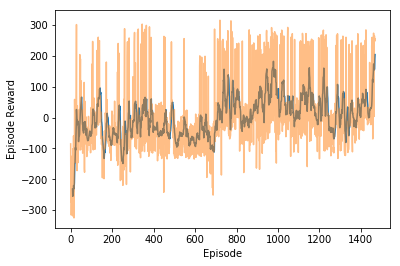

In [8]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

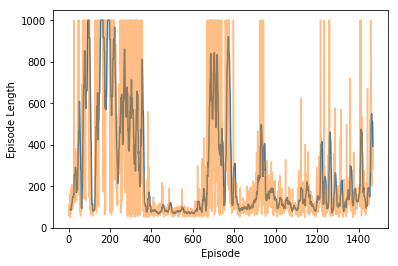

In [9]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')